Assignment 1, TIF320 Computational Materials and Molecular Physics.

**CID: ericlin**

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as lin
from tqdm import tqdm_notebook

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Problem 1: Hartree-Fock for Helium

 We want to solve the problem in section 4.3.2. in Thijssen. I.e., we want to solve the following problem:

$$ \sum_{pq} \left(h_{pq} + \sum_{rs}C_rC_sQ{prqs}\right)C_q = E' \sum_{pq}S_{pq}C_q $$

or written on matrix form:

$$ \mathbf{F} \mathbf{C} = E' \mathbf{S}\mathbf{C}$$

where 

$$ F_{pq} = h_{pq} + \sum_{rs}Q_{prqs}C_r C_s $$
$$ h_{pq} = \left<\chi_p \left| -\frac{1}{2}\nabla^2 - \frac{2}{r} \right| \chi_q \right>$$
$$ S_{pq} = \left< \chi_p|\chi_q \right> $$
$$ Q_{prqs} = \frac{2 \pi^{5/2}}{(\alpha_p+\alpha_q)(\alpha_r+\alpha_s)\sqrt{\alpha_p + \alpha_q + \alpha_r + \alpha_s}}$$
and 
$$ \phi(r) = \sum_{p=1}^4 C_p \chi_p(r)$$
$$ \chi_p(r) = e^{- \alpha_p r^2}$$

We will use:

$$ \alpha_1 = 0.297104 \\ \alpha_2=1.236745 \\ \alpha_3 = 5.749982 \\ \alpha_4 = 38.216677 $$
from the problem description.

Our procedure will be as follows:

1. Construct the matrices $h_{pq}$, $S_{pq}$ and the 4x4x4 tensor $Q_{prqs}$.
2. Guess initial values for $C_p$. 
3. Construct the F-matrix $F_{pq}$. Choose the initial values $C_p$ so that it is normalized to unit with regards to the overlap matrix before being inserted in $F$: 
$$\sum_{p,q=1}^4 C_p S_{pq} C_q = 1 = \mathbf{C} \cdot \mathbf{SC^T} $$
Thus, if a guess $\mathbf{C'}$ needs rescaling by some factor $k$ to find $\mathbf{C}$ it can be calculated as:

$$ 1 = \mathbf{C} \cdot \mathbf{SC^T} = 1 = k\mathbf{C'} \cdot \mathbf{S} k \mathbf{C'} \rightarrow k = \sqrt{1/(\mathbf{C'} \cdot \mathbf{S}\mathbf{C'^T})} $$

4. Solve the generalized eigenvalue problem $\mathbf{F} \mathbf{C} = E' \mathbf{S}\mathbf{C}$. Obtain a new vector $\mathbf{C}$.

5. Calculate the ground state energy as 

$$ E_G = 2 \sum_{pq} C_p C_q h_pq + \sum_{pqrs} Q_{pqrs} C_p C_q C_r C_s $$

6. Redo steps 3-5 iteratively until $E_G$ converges.

When constructing the matrices, we note that the wavefunction $\phi(r)$ is formulated as to exhibit spherical symmetry. We thus use a spherical coordinate system, in which the inner-product $\left< \chi_p|\chi_q \right>$ is given as

$$ \left< \chi_p|\chi_q \right> = 4\pi \int_0^{r_{max}} r^2 \chi_p \chi_q dr $$
since the $\chi_p$:s are real functions.


The Laplace operator $\nabla^2$ acting on $\chi_p$ is then taking the form

$$ \nabla^2 \chi_q = \frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2 \frac{\partial}{\partial r} e^{- \alpha_q r^2} \right) = \frac{1}{r^2}\frac{\partial}{\partial r} \left( -2\alpha_q r^3 e^{- \alpha_q r^2} \right) = (-6 \alpha_q + 4 \alpha_q^2 r^2 ) \chi_q.$$


In [2]:
def chi_p(alpha_p, r):
    '''Constructs chi_p given alpha_p and r'''
    return np.exp(-alpha_p*r**2)

def build_h(alpha, chi_vec, r):
    '''Builds the h-matrix h_pq'''
    l = len(alpha)
    h = np.zeros((l,l))
    for p in range(l):
        for q in range(l):
            h[p,q] = 4*np.pi * np.trapz( r**2 * chi_vec[p] * ( -0.5*( -6*alpha[q] + 4*alpha[q]**2 * r**2 ) - 2/r) * chi_vec[q], r)
    return h

def build_S(alpha, chi_vec, r):
    '''Builds the S_pq matrix'''
    l = len(alpha)
    S = np.zeros((l,l))
    for p in range(l):
        for q in range(l):
            S[p,q] = 4*np.pi * np.trapz( r**2 * chi_vec[p]*chi_vec[q], r )
    return S

def build_Q(alpha):
    '''Builds the Q_prqs 4x4x4x4 tensor'''
    l = len(alpha)
    Q = np.zeros((l,l,l,l))
    for p in range(l):
        for r in range(l):
            for q in range(l):
                for s in range(l):
                    Q[p,r,q,s] = 2*np.pi**(5/2) / ( (alpha[p]+alpha[q])*(alpha[r]+alpha[s])*np.sqrt(alpha[p]+alpha[q]+alpha[r]+alpha[s]) )
    return Q

def build_F(l, C, Q, h):
    '''Build the 4x4 F-matrix'''
    partial_sum_Q = 0
    for r in range(l):
        for s in range(l):
            partial_sum_Q += Q[:,r,:,s]*C[r]*C[s]
    F = h + partial_sum_Q
    return F

def get_EG(l, C, Q, h):
    '''Calculate the ground state energy'''
    EG = 0
    
    # First term
    for p in range(l):
        for q in range(l):
            EG += C[p]*C[q]*h[p,q]
    EG *= 2
    
    # Second term
    for p in range(l):
        for q in range(l):
            for r in range(l):
                for s in range(l):
                    EG += Q[p,r,q,s]*C[p]*C[q]*C[r]*C[s]
    return EG    

Lattice spacing: h=0.0050 a.u.
Is C normalized from the eigenvalue problem? False.
C thus needs to be normalized at the beginning of every step in the self-consistent loop.

Estimate for ground state energy using HF: EG ~= -2.8550061 a.u.
Final eigenvalue: Eprim ~= -0.9142327+0.0000000j a.u.


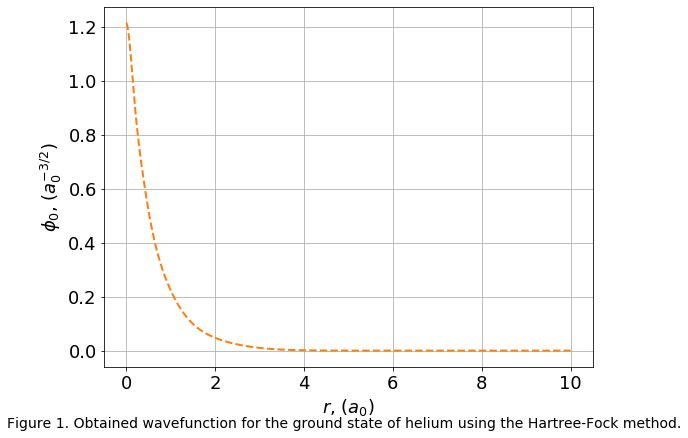

In [3]:
tol = (1/27.72)*1e-5  # 1e-5 eV -- 1 a.u. of energy = 27.72 eV => 1 eV = 1/27.72 a.u.
EGs = []  # Vector to store ground-state energies in
alphas = [0.297104, 1.236745, 5.749982, 38.216677]
l = len(alphas)
r = np.linspace(1e-10,10,2000)
print(f'Lattice spacing: h={r[1]-r[0]:.4f} a.u.')

chi_vec = np.zeros((l, len(r)))
for p in range(l):
    chi_vec[p,:] = chi_p(alphas[p], r)

# 1. Construct matrices
h = build_h(alphas, chi_vec, r)
S = build_S(alphas, chi_vec, r)
Q = build_Q(alphas)

# 2. Make an initial guess for C, and normalize it
C_ini = np.ones(l)  # Initial guess for C_p
k = 1/np.sqrt( C_ini.dot(np.matmul(S, C_ini.T)) )
C_ini *= k
assert np.abs( C_ini.dot(np.matmul(S, C_ini.T)) - 1 ) < tol # Check properly normalized

# 3. Construct the F-matrix
F = build_F(l, C_ini, Q, h)
eig_F, _ = lin.eig(F)
eig_S, _ = lin.eig(S)
    
# 4. Solve the generalized eigenvalue equation - once to get a base energy
ws, vecs = lin.eig( a=F, b=S )
g_idx = ws.argmin()  # Ground-state corresponds to lowest eigenvalue
w_g = ws[g_idx]
C = vecs[g_idx]
print(f'Is C normalized from the eigenvalue problem? {np.abs( C.dot(np.matmul(S, C.T)) - 1 ) < 1e-5}.')
print('C thus needs to be normalized at the beginning of every step in the self-consistent loop.')
print()

# 5. Get energy
EG = get_EG(l, C, Q, h)
EGs.append(EG)

# 6. Self-consistency loop
previous_EG = -999 # Initialize this for loop

while np.abs(EG-previous_EG) > tol:
    # Save EG as previous EG
    previous_EG = EG

    # 3. Construct the F-matrix
    F = build_F(l, C, Q, h)

    # 4. Solve the generalized eigenvalue equation - once to get a base energy
    # Use eigh since F and S are symmetric
    ws, vecs = lin.eig( a=F, b=S, right=True )
    g_idx = ws.argmin()  # Ground-state corresponds to lowest eigenvalue
    w_g = ws[g_idx]
    C = vecs[:,g_idx]

    # 5. Get energy
    # Normalize C first
    k = 1/np.sqrt( C.dot(np.matmul(S, C.T)) )
    C *= k
    assert np.abs( C.dot(np.matmul(S, C.T)) - 1 ) < tol # Check properly normalized
    
    EG = get_EG(l, C, Q, h)
    EGs.append(EG)

print(f'Estimate for ground state energy using HF: EG ~= {EGs[-1]:.7f} a.u.')
print(f'Final eigenvalue: Eprim ~= {w_g:.7f} a.u.')

# Plot wavefunction
phi0 = np.zeros(len(r))
for p in range(l):
    phi0 += C[p]*np.exp(-alphas[p]*r**2)
assert np.abs( 4*np.pi * np.trapz(r**2 * phi0**2, r) - 1 ) < tol # Check properly normalized

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(r, np.abs(phi0), color='C1', linestyle='--', linewidth=2)
ax.set_xlabel(r'$r$, ($a_0$)')
ax.set_ylabel(r'$\phi_0$, ($a_0^{-3/2}$)')
fig.text(0.55, 0, 'Figure 1. Obtained wavefunction for the ground state of helium using the Hartree-Fock method.', fontsize=14, ha='center')
plt.tight_layout()
ax.grid()

The obtained value for th ground state energy of helium using the Hartree-Fock method is thus $E_G = -2.8550061 \rm\, Ha$ of energy, with the corresponding ground state eigenvalue being $E'=-0.9142327 \rm\, Ha$ We also note that the ground state wavefunction $\phi_0$ is properly $L^2$-normalized.

# Problem 2: The Poisson Equation

The Hartree potential is generated by the charge distribution: 

$$ V_H(r) = \int dr' \frac{n(r')}{|r-r'|} \rightarrow \nabla^2 V_H(r) = -4\pi n(r)$$

The ground state density of the helium atom is $n(r) = 2n_s(r) = 2 |\varphi(r)|^2$ where $n_s$ is the density for one orbital (one electron). Introducing the electro-static potential $\nabla^2 V_{sH}(r) = -4\pi n_s(r)$ and using $U(r) = r V_{sH}(r)$ as well as $u(r) = \sqrt{4 \pi n_s(r)} = \sqrt{4\pi} r \varphi(r)$ we can write the Poisson equation on the form

$$ \frac{d^2}{dr^2}U(r) = -\frac{u^2(r)}{r}, \hspace{10pt} U(0) = 0, U(r_{max}) = 1 $$.

Finally, using $U_0(r) = U(r) - r/r_{max}$ we obtain 

$$ \frac{d^2}{dr^2}U_0(r) = -\frac{u^2(r)}{r}, \hspace{10pt} U_0(0) = 0, U_0(r_{max}) = 0 $$

We wish to solve this for $U(r)$. Rewriting using the finite difference method, we obtain the following system of equations (written on diagonal form utilizing the boundary conditions on $U_0$):

$$ A' U_0' = B$$
with

\begin{equation}
    A' = 
    \begin{bmatrix}
        -2 & 1 & 0 & 0 & 0 \\
         1 & -2 & 1 & 0 & 0 \\
         0 & 1 & -2 & 1 & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

\begin{equation}
    B = 
    \begin{bmatrix}
        b(r_1) = - 4 \pi h^2 |\varphi(r_1)|^2 r_1 - 0\\
        b(r_2) \\
        b(r_3) \\
        ... \\
    \end{bmatrix}
\end{equation}

Having obtained $U_0(r)$ from solving this system, we can then add the boundary conditions onto the solution.

We use Hartree units, such that $m_e = 1, e = 1, \hbar=1, 4\pi\epsilon_0 = 1, a_0=1$.

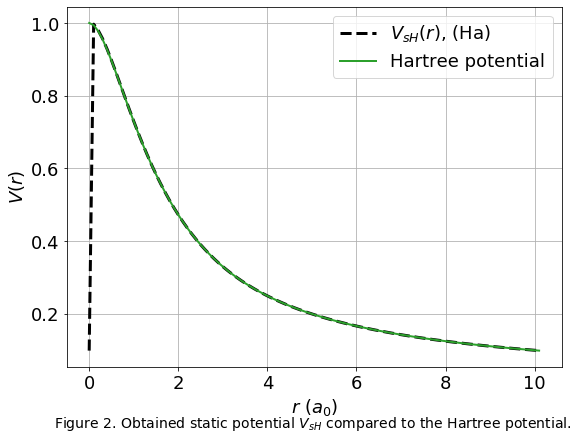

In [4]:
def hydrogen_ground_state(r):
    return 1/np.sqrt(np.pi) * np.exp(-r)

def hart_pot(r):
    return 1/r - (1+1/r)*np.exp(-2*r)

N = 100 # Number of  points
h = 0.1
r = np.array([h*i for i in range(1,N+1)]) # N points between endpoints
phi_dens = hydrogen_ground_state(r)**2
B = -np.array([4*np.pi*h**2*phi_dens[i]*r[i] for i in range(N)])
A_p = np.zeros((N,N)) + np.diagflat(-2*np.ones(N), k=0) + np.diagflat(np.ones(N-1), k=1) + np.diagflat(np.ones(N-1), k=-1)

U0_p = np.linalg.solve(A_p, B) # Solve the system of equations for U_0

# Pad U0_p with zeros for boundary conditions and add endpoints to r
r = np.insert(r, 0, 1e-10)  # Can't be zero to avoid division by 0
r = np.insert(r, N+1, r[-1]+h)
U0_p = np.insert(U0_p, 0, 0)
U0_p = np.insert(U0_p, N+1, 0)

rmax = r[-1]  # The endpoint distance
U = U0_p + r/rmax # Extract U
Vsh = U/r # Extract the static potential

# PLot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(r, Vsh, color='k', linestyle='--', linewidth=3, label=r'$V_{sH}(r)$, (Ha)')
ax.plot(r, hart_pot(r), color='C2', linestyle='-', linewidth=2, label='Hartree potential')
fig.text(0.55, 0, 'Figure 2. Obtained static potential $V_{sH}$ compared to the Hartree potential.', fontsize=14, ha='center')
ax.legend(loc='best')
ax.grid()
ax.set_xlabel(r'$r$ $(a_0)$')
ax.set_ylabel(r'$V(r)$')
plt.tight_layout()

As we can see in the figure, the obtained electro-static potential $V_{sH}$ for a single electron matches the Hartree potential as expected.

# Problem 3: Kohn-Sham equation

The Kohn-Sham equation equation takes the form:

$$ \left[ -\frac{1}{2}\frac{d^2}{dr^2} -\frac{2}{r} + V_H(r) + V_x(r) + V_c(r) \right]u(r) = \epsilon u(r) $$

with boundary conditions $u(0) = u(r_{max}) = 0$. Rewriting this with the finite difference method, we obtain: 

$$ -\frac{1}{2h^2}\left[u(r_{i+1})+u(r_{i-1})\right] + \left[\frac{1}{h^2} -\frac{2}{r_i} + V_H(r_i) + V_x(r_i) + V_c(r_i) \right]u(r_i) = \epsilon u(r_i) $$

If we rewrite this on matrix form, we obtain the matrix equation: 

$$ Cu = \epsilon \tilde{u} $$
where $\tilde{u} = [u(r_1), u(r_2), ... , u(r_{max}-h)]$ i.e. for $r$ in the range $(h, r_{max}-h)$. This is due to the eigenvalue equation being undefined for the endpoints. Thus $C$ is NxN+2, $u$ is N+2 and $\tilde{u}$ is N.

Using the same trick as in problem 2, we can handle these problematic points by subtracting $-\frac{1}{2h^2}u(r_0)$ and $-\frac{1}{2h^2}u(r_{max})$ from equations for rows 1 and N in $C$. Since they are $u(0) = u(r_{max})=0$ we obtain the equation

$$ C' \tilde{u} = \epsilon \tilde{u} $$
which is a problem on diagonal form, with the boundary conditions baked into the matrix. They will thus automatically appear in our eigenvectors $\tilde{u}$. $C'$ is on the form

\begin{equation}
    C' = 
    \begin{bmatrix}
        \frac{1}{h^2} -\frac{2}{r_1}+V_H(r_1) + V_x(r_1) + V_c(r_1) & -\frac{1}{2h^2} & 0 & 0 & 0 \\
         -\frac{1}{2h^2} & \frac{1}{h^2} -\frac{2}{r_2}+V_H(r_2) + V_x(r_2) + V_c(r_2) & -\frac{1}{2h^2} & 0 & 0 \\
         0 & -\frac{1}{2h^2} & \frac{1}{h^2} -\frac{2}{r_3}+V_H(r_3) + V_x(r_3) + V_c(r_3) & -\frac{1}{2h^2} & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

For our problem, we wish to solve the radial equation for the hydrogen atom. We thus set $V_H = V_x = V_c = 0$. We call the resulting eigenvalue equation 

$$ \Gamma \tilde{u} = E \tilde{u}$$

with 

\begin{equation}
    \Gamma = 
    \begin{bmatrix}
        \frac{1}{h^2} -\frac{1}{r_1} & -\frac{1}{2h^2} & 0 & 0 & 0 \\
         -\frac{1}{2h^2} & \frac{1}{h^2} -\frac{1}{r_2}& -\frac{1}{2h^2} & 0 & 0 \\
         0 & -\frac{1}{2h^2} & \frac{1}{h^2} -\frac{1}{r_3} & -\frac{1}{2h^2} & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

In [5]:
N = 2000 # Number of  points
h = 0.005
r = np.array([(i+1)*h for i in range(N)]) # N points between endpoints
Gamma = np.zeros((N,N)) + np.diagflat((1/h**2 - 1/r)*np.ones(N), k=0) + np.diagflat(-1/(2*h**2)*np.ones(N-1), k=1) + np.diagflat(-1/(2*h**2)*np.ones(N-1), k=-1)

eigs, eigv = np.linalg.eigh(Gamma)  # Solve the eigenvalue problem for eigenvectors and eigenfunctions 
E0 = eigs[0]  # The eigenvalues & vectors are returned in ascending order, thus with the ground state first
u0 = eigv[:,0]  # Normalized eigenvector

Here we obtain the normalized eigenvector for the ground state, i.e. $u_0(r)$ which is normalized. Since $u_0(r) \propto \varphi_0(r)$ this means that the wavefunction is also normalized. However, we want it to be $L2$-normalized so we have to renormalize the wave function. We require:

$$ 1 = k^2 \int_0^{r_{max}} |\varphi(x)|dx =  k^2 4 \pi \int_0^{r_{max}} |\varphi(r)|^2 r^2 dr \rightarrow k = \left(4 \pi \int_0^{r_{max}} |\varphi(r)|^2 r^2 dr \right)^{-\frac{1}{2}}$$
$$ \rightarrow \varphi_{L2}(r) = \varphi(r)/k. $$

Ground state energy: E0 = -0.499996 a.u.


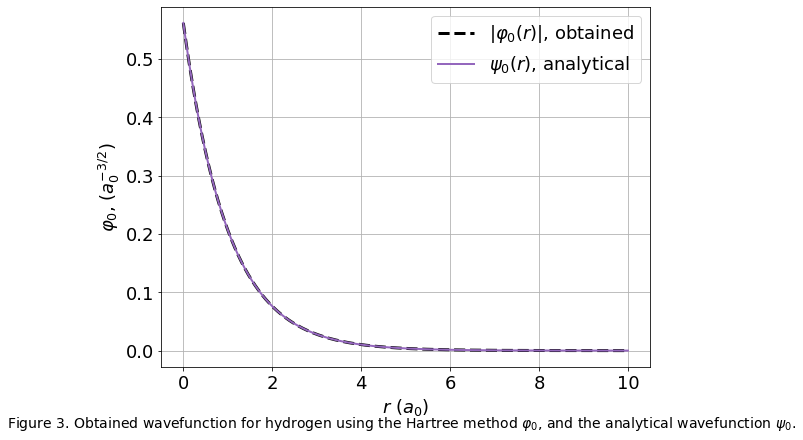

In [11]:
phi0_wrong_norm = u0/(np.sqrt(4*np.pi)*r)
k2 = 4*np.pi * np.trapz((phi0_wrong_norm*r)**2, r)  # The 4pi comes from the integration over all space of our symmetric wavefunction - not just radial wavefunction
phi0 = phi0_wrong_norm / np.sqrt(k2)  # L2-normalize the wave-function
# print(np.trapz(4*np.pi*(phi0*r)**2, r))

print(f'Ground state energy: E0 = {E0:.6f} a.u.')

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(r, np.abs(phi0), color='k', linestyle='--', linewidth=3, label=r'$|\varphi_0(r)|$, obtained')
ax.plot(r, hydrogen_ground_state(r), color='C4', linestyle='-', linewidth=2, label=r'$\psi_0(r)$, analytical')
ax.legend(loc='best')
ax.grid()
ax.set_xlabel(r'$r$ $(a_0)$')
ax.set_ylabel(r'$\varphi_0$, ($a_0^{-3/2}$)')
fig.text(0.55, 0, r'Figure 3. Obtained wavefunction for hydrogen using the Hartree method $\varphi_0$, and the analytical wavefunction $\psi_0$.', fontsize=14, ha='center')
plt.tight_layout()

Here we seem to get $\varphi(r) = -\psi(r)$. But this is no problem, and is probably only an artefact of the eigenvalue solving routine. If $v$ is an eigenvector to $Av = \lambda v$, then $-v$ is an eigenvector to $A$ with the same eigenvalue. So we can take the absolute value.

We get the ground state energy to be $E_0 = -0.499996 \rm\, Ha$, which matches the analytical value for hydrogen of $E_0 = -0.5 \rm\, Ha.$. We also note that the obtained wavefunction matches the analytical wavefunction.

# Problem 4 - Iterative solution

We need to iteratively improve our estimate of the ground state energy in the Hartree approximation. We thus use the solution of the Kohn-Sham equation, but omit the exchange-correlation term as well as the self-interaction from the Hartree potential, thus setting $V_H = V_{sH}$. Our procedure will thus look like 

1. Guess the initial density $|\varphi_{i}|^2$.
2. Obtain the estimate for the Hartree potential using $A' U_0' = B$ from Problem 2 to solve for $V_{sH} = U/r$.
3. Obtain the estimate of the ground state energy and the new density from the eigenvalue problem as in Problem 3. Here, we use a different matrix $\Lambda$, which yields the eigenvalue equation  $\Lambda \tilde{u} = \epsilon \tilde{u}$. The energy will be computed as:

$$ E_0 = 2 \epsilon - 2 \int dr u^2(r) \left[ \frac{1}{2}V_H(r) \right]  $$

We repeat this scheme until the ground state energy has converged. The matrix $\Lambda$ has the following form: 

\begin{equation}
    \Lambda = 
    \begin{bmatrix}
        \frac{1}{h^2} -\frac{2}{r_1} + V_{sH}(r_1) & -\frac{1}{2h^2} & 0 & 0 & 0 \\
         -\frac{1}{2h^2} & \frac{1}{h^2} -\frac{2}{r_2} + V_{sH}(r_2) & -\frac{1}{2h^2} & 0 & 0 \\
         0 & -\frac{1}{2h^2} & \frac{1}{h^2} -\frac{2}{r_3} + V_{sH}(r_3)  & -\frac{1}{2h^2} & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

We use the ground state of hydrogen as our input density:

$$ \varphi_i(r) = \frac{1}{\sqrt{\pi}} e^{-2r}$$

To check for convergence with regards to $r_{max}$ and $h$, three passes of the self-consistent loop will be completed. First, $r_{max}$ and $h$ are set what I deem probable values: $r_{max}=10 \rm\, a_0$, $h=0.01 \rm\, a_0$. For the second pass, $r_{max}$ is doubled. For the third pass, in addition to doubling $r_{max}$ I also halve $h$. Then, the results from all passes are compared from which it can be deemed if the computation is converged with regards to $r_{max}$ and $h$.

#### Note that the code for problems 4, 5, 6 are in the same functions, but that what is executed is controlled by the variable "problem".

In [13]:
def eps_x(n):
    return -3/4 * (3*n/np.pi)**(1/3)

def deriv_eps_x(n):
    return -3/(4*np.pi) * (3*n/np.pi)**(-2/3)

def eps_c(n):
    rs = ( 3/(4*np.pi*n) )**(1/3)
    eps_c_vec = np.zeros(len(rs))
    geq1_idx = np.where(np.abs(rs)>=1)[0][0]
    # Define constants
    A = 0.0311
    B = -0.048
    C = 0.0020
    D = -0.0116
    
    gamma = -0.1423
    b1 = 1.0529
    b2 = 0.3334
    
    for i, ri in enumerate(rs):
        if ri < geq1_idx:
            eps_c_vec[i] = A*np.log(ri) + B + C*ri*np.log(ri)+D*ri
        else:
            eps_c_vec[i] = gamma/( 1+ b1*np.sqrt(ri) + b2*ri )
    return eps_c_vec

def deriv_eps_c(n):
    '''Note that the derivative is w.r. using the chain rule!'''
    rs = ( 3/(4*np.pi*n) )**(1/3)
    d_eps_c_vec = np.zeros(len(rs))
    geq1_idx = np.where(np.abs(rs)>=1)[0][0]
    
    # Define constants
    A = 0.0311
    B = -0.048
    C = 0.0020
    D = -0.0116
    
    gamma = -0.1423
    b1 = 1.0529
    b2 = 0.3334
    
    for i, ri in enumerate(rs):
        if ri < geq1_idx:
            d_eps_c_vec[i] = A/ri + C*np.log(ri) + C + D
        else:
            d_eps_c_vec[i] = -gamma*( b1 + 2*b2*np.sqrt(ri)) / ( 2*np.sqrt(ri) * (1 + b1*np.sqrt(ri) + b2*ri)**2 )
    d_eps_c_vec *= - (1/rs)**(4/3) / ( 6**(2/3) * np.pi**(1/3) ) # dn/drs
    return d_eps_c_vec 

def iterative_step(phi0, rmax, h, problem):
    '''Perform a step of the iterative solution. Prepared for Problems 5 and 6 with V_x and V_c.'''
     #******** Calculate new N, r and pad phi_density ***********
    N = int(rmax/h-1)
    r = np.array([(i+1)*h for i in range(N)]) # N points between endpoints
    phi_sq = phi0**2
    phi_sq = np.pad(phi_sq, (0,N-len(phi_sq)), 'edge')  # Pad density with last value to new maximum value
    A_p = np.zeros((N,N)) + np.diagflat(-2*np.ones(N), k=0) + np.diagflat(np.ones(N-1), k=1) + np.diagflat(np.ones(N-1), k=-1) 
    
    #******** Estimate V_sH ***********
    B = -np.array([4*np.pi*h**2*phi_sq[i]*r[i] for i in range(N)])
    U0_p = np.linalg.solve(A_p, B) # Solve the system of equations for U_0
    U = U0_p + r/rmax # Extract U
    V_sH = U/r # Extract the static potential
    
    if problem==4:
        V_H = V_sH
        V_x = np.zeros((N))
        V_c = np.zeros((N))
    elif problem==5:
        V_H = 2 * V_sH
        n = 2 * phi_sq
        V_x = eps_x(n) + n*deriv_eps_x(n)
        V_c = np.zeros((N))
    elif problem==6:
        V_H = 2 * V_sH
        n = 2 * phi_sq
        V_x = eps_x(n) + n*deriv_eps_x(n)
        V_c = eps_c(n) + n*deriv_eps_c(n)
    
    #******** Estimate E_0 and phi0 ***********
    Lambda = np.zeros((N,N)) + np.diagflat((1/h**2 - 2/r)*np.ones(N) + V_H + V_x + V_c, k=0) + np.diagflat(-1/(2*h**2)*np.ones(N-1), k=1) + np.diagflat(-1/(2*h**2)*np.ones(N-1), k=-1)

    eigs, eigv = np.linalg.eigh(Lambda)  # Solve the eigenvalue problem for eigenvectors and eigenfunctions 
    eps = eigs[0]  # The eigenvalues & vectors are returned in ascending order, thus with the ground state first
    u0 = eigv[:,0]  # Normalized eigenvector
    
    phi0_wrong_norm = u0/(np.sqrt(4*np.pi)*r)
    k2 = 4*np.pi * np.trapz((phi0_wrong_norm*r)**2, r)  # The 4pi comes from the integration over all space of our symmetric wavefunction - not just radial wavefunction
    phi0 = phi0_wrong_norm / np.sqrt(k2)  # L2-normalize the wave-function
    
    # Calculate the ground state energy
    u2 = 4 * np.pi * r**2 * phi0**2 
    # Calculate these again - a bit wasteful but ensures correct wavefcn etc.
    if problem==4:
        eps_xc = 0
        Vxc = 0
    elif problem==5:
        n = 2 * phi0**2
        eps_xc = eps_x(n)
        V_x = eps_x(n) + n*deriv_eps_x(n) # Get the new exchange potential - linearity
        V_c = 0 
        Vxc = V_x + V_c  # Assume the potential can be split in two
    elif problem==6:
        n = 2 * phi0**2
        eps_xc = eps_x(n) + eps_c(n)
        V_x = eps_x(n) + n*deriv_eps_x(n) # Get the new exchange potential - linearity
        V_c = eps_c(n) + n*deriv_eps_c(n)
        Vxc = V_x + V_c 
        
    E0 = 2*eps - 2*np.trapz(u2 * ( 0.5*V_H + Vxc - eps_xc ), r)
#     print(f'Ground state energy: E0 = {E0:.6f} a.u.')
    
    #******** Return E_0 and phi_0 ***********
    return E0, phi0, eps, r, N

In [28]:
def self_consistentV2(p=4, max_iters=500, tol=1e-5, rmax=10, h=0.02):    
    '''
    Performs the self-consistent loop for a certain problem, and plots the results
    max_iters: maximum iterations for convergence of each rmax and h.
    '''
    # Iteration parameters
    energies = []  # Ground-state energies
    iters = 0
    previous_E = -999 # No previous energy

    #******** Initial Step ********* 
    N = int(rmax/h-1)  # Rmax = (N+1)*h for N+2 steps including 0 and rmax
    r = np.array([(i+1)*h for i in range(N)]) # N points between endpoints
    # Make an initial estimate of the energy and ground state density:
    E0, phi0, eps, r, N = iterative_step(hydrogen_ground_state(r), rmax, h, problem=p)
    energies.append(E0)

    #******** Iteratively calculate energy *********
    while np.abs(E0-previous_E) > tol and iters<max_iters:
        previous_E = E0  # Save previous energy
        E0, phi0, eps, r, N = iterative_step(phi0, rmax, h, problem=p)
        energies.append(E0)
        iters += 1

    print(f'Converged in {iters} iterations.')
    print(f'Ground state energy: {energies[-1]:.7f} a.u., eigenvalue: {eps:.7f}')

#     #******** Plot wavefunctions *********
#     ax_wave.plot(r, np.abs(phi0), linestyle=':', alpha=0.8, linewidth=2, label=rf'$\phi_0$, rmax={rmax:.2f}, h={h:.4f}')   

#     #******** Plot energies *********
#     ax_energy.plot(energies, linestyle='--', linewidth=3, label=f'E0 = {energies[-1]:.4f}, rmax={rmax:.2f}, h={h:.4f}')
    return E0, np.abs(phi0), r


def run_problem(problem=4):
    '''Parameterized runner of each problem for problems 4,5,6 since they are basically the same code.'''
    max_iters = 500
    tol = (1/27.72)*1e-5  # 1e-5 eV

    # Figures for plots
    fig, ax_wave = plt.subplots(figsize=(12,6))
    fig, ax_energy = plt.subplots(figsize=(12,6))

    rmaxs = [2,4,6,8,10]
    hs = [0.1,0.05,0.025,0.01, 0.005]
    
    Es = []
    r_iters = 0  # Iterations of increasing rmax
    
     # Run the self-consistent loop for various values of rmax and h
    for rmax in rmaxs:
        print(f"------------ rmax = {rmax:.3f} -----------")
        E, phi0, r = self_consistentV2(problem, max_iters, tol, rmax=rmax, h=hs[0])  
        Es.append(E)
        print("----------------------------- ---------------")
        print()
        r_iters += 1
        
    for h in hs:
        print(f"------------ h = {h:.3f} -----------")
        E, phi0, r = self_consistentV2(problem, max_iters, tol, rmax=rmaxs[-1], h=h)  
        Es.append(E)
        print("----------------------------- ---------------")
        print()
   


    # Various plot details
    ax_wave.plot(r, phi0, linestyle=':', alpha=0.8, linewidth=2, label=rf'$\phi_0$')
    ax_wave.legend(loc='best')
    ax_wave.grid()
    ax_wave.set_xlabel(r'$r$ $(a_0)$')
    ax_wave.set_ylabel(r'He ground state') 
    
    ax_energy.plot(Es, linestyle='--', linewidth=3, label=f'E0 = {Es[-1]:.4f} Ha')
    ax_energy.axhline(-2.8545, color='C5', linewidth=3, label='Hartree-Fock value, problem 1')
    ax_energy.axhline(-2.9033, color='C6', linewidth=3, label='Experimental value')
    ax_energy.axvline(r_iters, color='k', linewidth=2, label=r'Start to decrease $h$')
    ax_energy.legend(loc='best')
    ax_energy.grid()
    ax_energy.set_xlabel(r'Iteration of increasing $r_{max}$ and decreasing $h$')
    ax_energy.set_ylabel(r'$E_0$')

------------ rmax = 2.000 -----------
Converged in 9 iterations.
Ground state energy: -2.5087610 a.u., eigenvalue: -0.6339126
----------------------------- ---------------

------------ rmax = 4.000 -----------
Converged in 13 iterations.
Ground state energy: -2.8152359 a.u., eigenvalue: -0.8948769
----------------------------- ---------------

------------ rmax = 6.000 -----------
Converged in 13 iterations.
Ground state energy: -2.8180093 a.u., eigenvalue: -0.9000310
----------------------------- ---------------

------------ rmax = 8.000 -----------
Converged in 13 iterations.
Ground state energy: -2.8177292 a.u., eigenvalue: -0.8998067
----------------------------- ---------------

------------ rmax = 10.000 -----------
Converged in 13 iterations.
Ground state energy: -2.8175432 a.u., eigenvalue: -0.8996213
----------------------------- ---------------

------------ h = 0.100 -----------
Converged in 13 iterations.
Ground state energy: -2.8175432 a.u., eigenvalue: -0.8996213
------

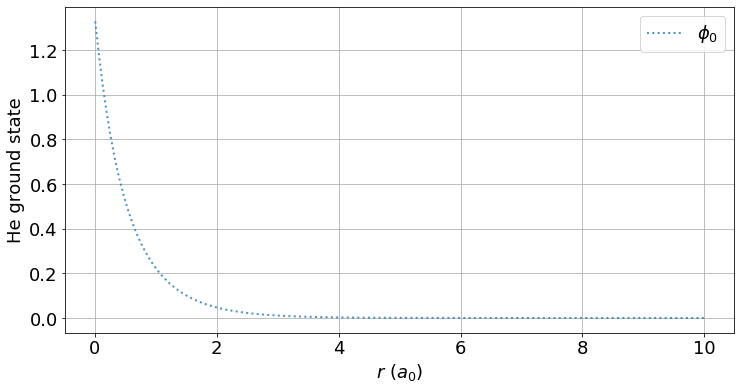

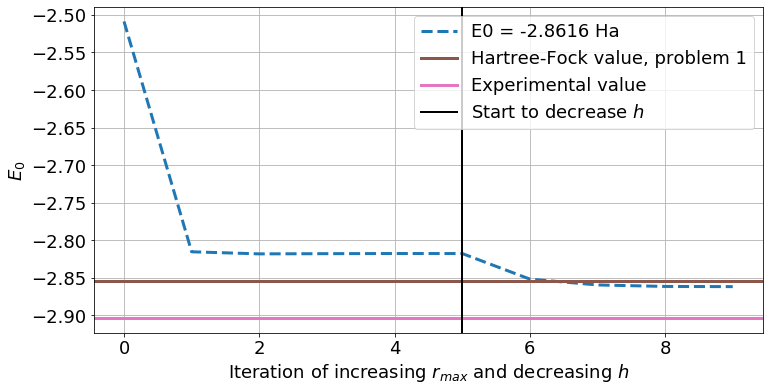

In [29]:
run_problem(problem=4)

Using the Hartree method, the ground state energy converges to $E_0 \approx -2.8615944 \rm\, a.u.$ and an eigenvalue of $\epsilon = -0.9179226 \rm\, a.u.$ , which can be compared to the result from the Hartree-Fock method (problem 1) $E_G \approx -2.8454 \rm\, a.u.$ Comparing the wavefunctions, we note that they are very similar in shape. The energy in the Hartree method (problem 4) is lower than the energy as computed by the Hartree-Fock method(problem 1), i.e. closer to the experimental value. This makes sense, since using the Hartree-Fock method we automatically include exchange effects, due to the use of a Slater determinant basis. This raises the energy as compared to the Hartree method which does not take that into account.

Furthermore, we note that the algorithm seems to be somewhat converged with regards to $r_{max}$ and $h$ since their values does not seem to affect the result that much, neither the wavefunction nor the energy. Some variations in the fourth decimal point can be seen when decreasing $h$, but I've tried decreasing it further than $h=0.05$ which results in the code taking several hours to run. Hence it is in my opinion not realistic to lower it further. 

# Problem 5 - Adding exchange contributions

We now add exchange contributions to problem 4. We use the full Hartree potential, i.e. setting $V_H=2 V_{sH}$. Using the LDA approximation, we can write the exchange-correlation potential as:

$$ \epsilon_{xc} = \epsilon_x + \epsilon_c = \epsilon_x + 0 = -\frac{3}{4}\left(\frac{3n}{\pi}\right)^{1/3}$$
$$ V_{xc} = \epsilon_{xc} + n \frac{d}{dn}\epsilon_{xc} = -\frac{3}{4}\left(\frac{3n}{\pi}\right)^{1/3} - n\frac{3}{4\pi}\left(\frac{3n}{\pi}\right)^{-2/3} $$

I also interpret the potential to be additive, i.e.
$$ V_{xc} = V_x + V_c. $$ 
Now, the ground state energy is computed as

$$ E_0 = 2 \epsilon - 2 \int dr u^2(r) \left[ \frac{1}{2}V_H(r) + V_x(r) - \epsilon_x(r) \right]  $$

------------ Baseline calculation -----------
Converged in 20 iterations.
Ground state energy: -2.7232772 a.u., eigenvalue: -0.5168597
----------------------------- ---------------

--------------- Increase Rmax ---------------
Converged in 20 iterations.
Ground state energy: -2.7232761 a.u., eigenvalue: -0.5168589
----------------------------- ---------------

------------ Increase Rmax and h ------------
Converged in 20 iterations.
Ground state energy: -2.7235521 a.u., eigenvalue: -0.5169426


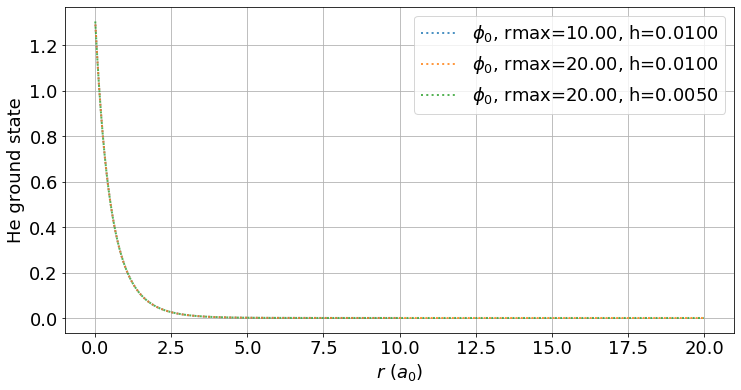

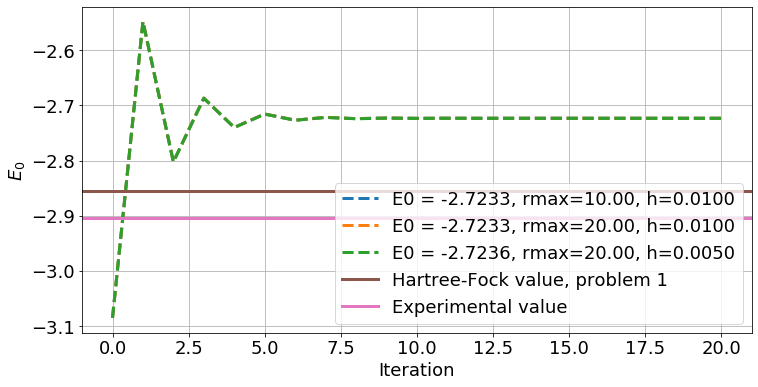

In [10]:
run_problem(problem=5)

Adding exchange contributions to the Hartree method raises the estimate of the energy of the ground state by about 5\%, from $E_{0,4} \approx -2.86 \rm \, a.u.$ to $E_{0,5} \approx -2.7235521 \rm\,a.u.$, and the eigenvalue $\epsilon \sim -0.5169426 \rm\, a.u.$ This is reasonable due to us adding the exchange effects, which includes Pauli repulsion, effectively raising the energy of the system. But to obtain a better estimate of the ground state energy using this DFT method, we need to add the term arising from the electrons being correlated in our system.

# Problem 6

Same as problem 5, but we add the correlation term. The added terms are 

$$ \epsilon_c(rs) = \frac{\gamma}{1+\beta_1\sqrt{r_s} + \beta_2 r_s}, \hspace{10pt} rs \geq 1  $$
$$ \epsilon_c(rs) = A \log{r_s} + B + C r_s\log{r_s} + D r_s, \hspace{10pt} rs \le 1  $$

Using the chain rule, we can compute the derivative 

$$ \frac{d}{dn} \epsilon_c  = \frac{d r_s}{dn} \frac{d \epsilon_c}{d r_s}. $$

$$ \frac{d\epsilon_c}{dr_s} = -\frac{\gamma(\beta_1+2\beta_2\sqrt{r_s})}{2\sqrt{r_s}(1 + \beta_1\sqrt{r_s} + \beta_2 r_s )^2}, \hspace{10pt} rs \geq 1  $$
$$ \frac{d\epsilon_c}{dr_s} = \frac{A}{r_s} + C\log{r_s} + C + D, \hspace{10pt} rs \le 1  $$
$$ \frac{dr_s}{dn} = -\frac{\left(\frac{1}{rs}\right)^{4/3}}{6^{2/3} \pi^{1/3}}, \hspace{10pt} \forall r_s  $$

The ground state energy finally is computed as

$$ E_0 = 2 \epsilon - 2 \int dr u^2(r) \left[ \frac{1}{2}V_H(r) + V_{xc}(r) - \epsilon_{xc}(r) \right]  $$

------------ Baseline calculation -----------
Converged in 19 iterations.
Ground state energy: -2.8373206 a.u., eigenvalue: -0.5709970
----------------------------- ---------------

--------------- Increase Rmax ---------------
Converged in 19 iterations.
Ground state energy: -2.8373196 a.u., eigenvalue: -0.5709961
----------------------------- ---------------

------------ Increase Rmax and h ------------
Converged in 19 iterations.
Ground state energy: -2.8376102 a.u., eigenvalue: -0.5711573


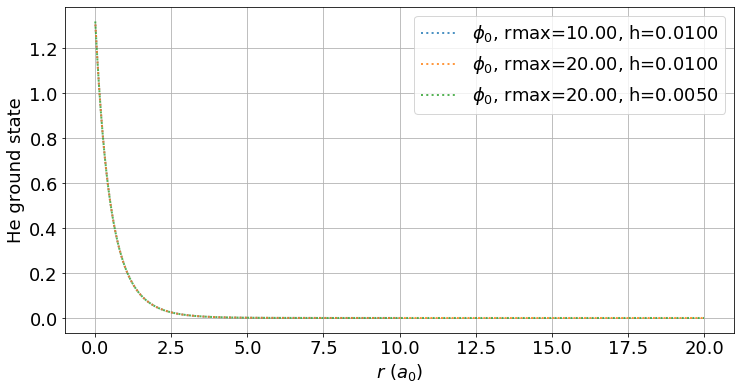

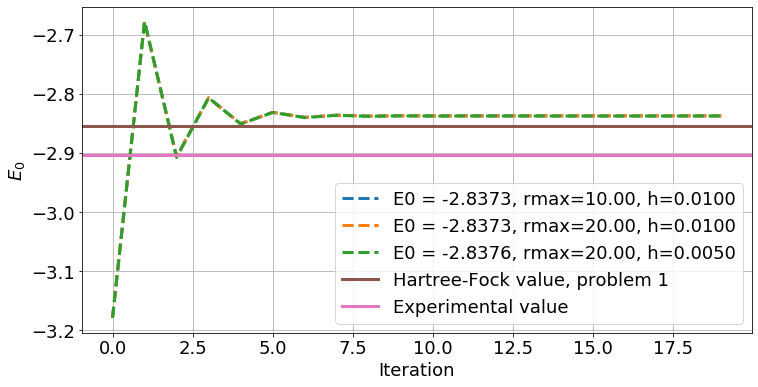

In [11]:
run_problem(problem=6)

Finally, by adding correlation energy we arrive at a ground state energy which is $E_{0,6} \approx 2.8376102 \rm\, a.u$, and the eigenvalue $\epsilon \sim -0.5711573 \rm\, a.u.$ The obtained energy is closer to the ground state energy than what was obtained in problem 5, but it still further away from the experimental value of $E_{0,exp} \approx -2.90 \rm\, a.u.$ than what we obtained with the Hartree-Fock method in problem 1 and with the Hartree method in problem 4. This is in line with the fact that the DFT method does not perform as well as the Hartree-based methods for smaller systems; for instance, Hartree-Fock handles exchange effects perfectly which can only be approximated in the Kohn-Sham-based DFT method. However, this relatively simple DFT calculation resulted in a ground-state energy that is not too far off from the experimental value. In combination with the fact that DFT scales better for larger systems (not shown in this assignment) we can draw the conclusion that DFT is a suitable tool for handling many-body quantum systems, when the size of the system makes it intractible for methods based around Hartree and Hartree-Fock.